# **Tìm hiểu về YOLOv7: Giải quyêt bài toán Object Detection**

## **I. Giới thiệu**

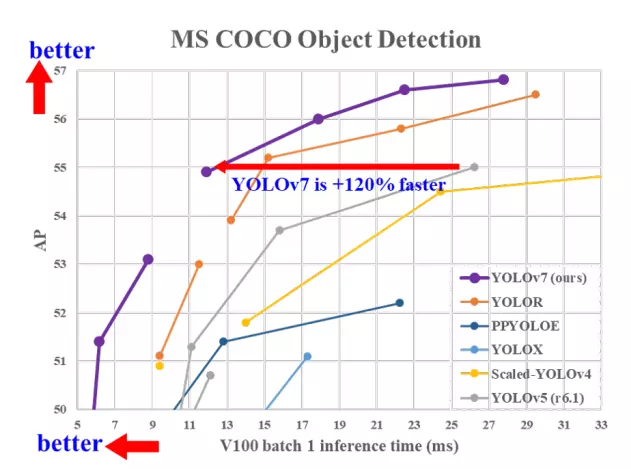

### **1. Các khái niệm, kiến thức cần nắm về YOLOv7:**

#### **a. Bag-of-freebies**
Bag-of-freebies (BoF): BoF là các kĩ thuật được thêm vào trong YOLOv4. BoF là các kỹ thuật được thêm vào trong training có thể **tăng độ chính xác** mà không tăng **thời gian xử lý** của model: Kĩ thuật Augmentations, hàm loss, label smoothing,...

#### **b. Label Assignment**

Kỹ thuật Anchor box được sử dụng rộng rãi trong YOLO ở các version trước, nhưng với sự ra đời của [FCOS](https://arxiv.org/abs/1904.01355) đạt độ chính xác khá cao mà không cần sử dụng anchor box.

Anchor-free training nhanh hơn dùng ít GPU/CPU hơn khi sử dụng Anchor Box (Anchor-based) nhưng độ chính xác không tốt bằng cho tới khi [ATSS](https://paperswithcode.com/paper/bridging-the-gap-between-anchor-based-and) xuất hiện.

#### **c. Re-parameterization**

Là kỹ thuật lần đầu áp dụng trong YOLOv5. Là việc thực hiện hợp nhất lớp Convlution (Conv) và lớp BatchNorm(BN) vào làm một lớp, hiên việc inference diễn ra nhanh hơn.

In [1]:
import torch 
import torch.nn as nn
def fuse_conv_and_bn(conv, bn):
    # tạo ra một lớp Conv mới là lớp Conv kết hợp BN với lớp Conv cũ
    fusedconv = nn.Conv2d(conv.in_channels,
                          conv.out_channels,
                          kernel_size=conv.kernel_size,
                          stride=conv.stride,
                          padding=conv.padding,
                          groups=conv.groups,
                          bias=True).requires_grad_(False).to(conv.weight.device)

    # Prepare filters
    w_conv = conv.weight.clone().view(conv.out_channels, -1) # weight của lớp conv cũ
    w_bn = torch.diag(bn.weight.div(torch.sqrt(bn.eps + bn.running_var))) # tạo ra phân số trong phép tính (1)
    fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape)) # tính weight mới cho lớp Conv mới theo công thức (1)

    # Prepare spatial bias
    b_conv = torch.zeros(conv.weight.size(0), device=conv.weight.device) if conv.bias is None else conv.bias
    b_bn = bn.bias - bn.weight.mul(bn.running_mean).div(torch.sqrt(bn.running_var + bn.eps)) 
    fusedconv.bias.copy_(torch.mm(w_bn, b_conv.reshape(-1, 1)).reshape(-1) + b_bn) # công thức (2)

    return fusedconv

#### **d. Model Scaling**

Kỹ thuật được áp dụng trong EfficientNet với ý tưởng scale tổng hợp 3 chiều của mạng neural: chiều sâu, chiều rộng, chiều độ phân giải của input images. Việc scale kết hợp các chiều của mạng neural cho ra kết quả tốt, mang lại hiệu quả cao.

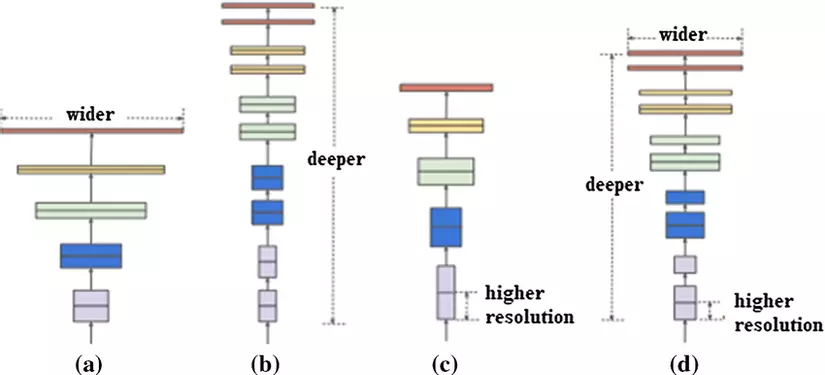

#### **e. Implicit Knowledge**

Implicit Knowledge (Kiến thức tiềm ẩn) được giới và áp dụng lần đầu vào Object Detection ở YOLOR.  

Trước tiên chúng ta nên biết explicit knowledge (học trực tiếp) là gì? Theo YOLOR định nghĩa explicit knowledge là kiến thức thông qua sự tiếp xúc với các input. Còn implicit knowledge là một thứ gì đó mà model sẽ tự rút ra được trong quá trình training, độc lập với input.

YOLOR đề xuất 3 cách biểu diễn implicit knowledge, tuy nhiên biểu diễn đơn giản nhất, dưới dạng vector, được YOLOR sử dụng đạt hiểu quả khá tốt.

Implicit knowledge được kết hợp vào mạng nơ-rơn theo 2 cách, cộng và nhân:

In [ ]:
# Implicit cộng
class ImplicitA(nn.Module):
    def __init__(self, channel, mean=0., std=.02):
        super(ImplicitA, self).__init__()
        self.channel = channel
        self.mean = mean
        self.std = std
        self.implicit = nn.Parameter(torch.zeros(1, channel, 1, 1))
        nn.init.normal_(self.implicit, mean=self.mean, std=self.std)

    def forward(self, x):
        return self.implicit + x

In [ ]:
# Implicit nhân
class ImplicitM(nn.Module):
    def __init__(self, channel, mean=0., std=.02):
        super(ImplicitM, self).__init__()
        self.channel = channel
        self.mean = mean
        self.std = std
        self.implicit = nn.Parameter(torch.ones(1, channel, 1, 1))
        nn.init.normal_(self.implicit, mean=self.mean, std=self.std)

    def forward(self, x):
        return self.implicit *  x

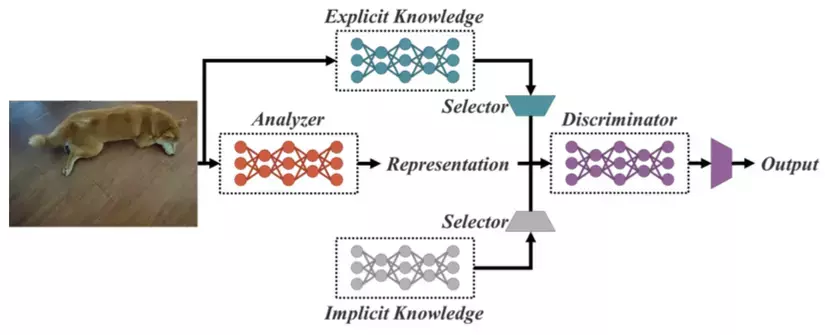

#### **f. Deep Supervision (Auxiliary head)**

Là kỹ thuật được sử dụng nhiều ở bài toán segmentation, được giới thiệu lần đầu tiên trong Inception Network. Từ các layer khá nông của model, ta tạo ra một head ảo, bắt model predict luôn từ những lớp khá nông. Nhiều giả thuyết cho rằng, việc bắt model predict từ sớm có thể ảnh hưởng lên ngay lớp nông để học thêm các đăc trưng cần thiết chứ không phải đến các lớp sâu nữa, nên quá trình học trở nên nhanh và dễ dàng hơn.

Trong quá trình inference, chúng ta sẽ bỏ đi auxiliary head và chỉ sử dụng head gốc để đưa ra predict


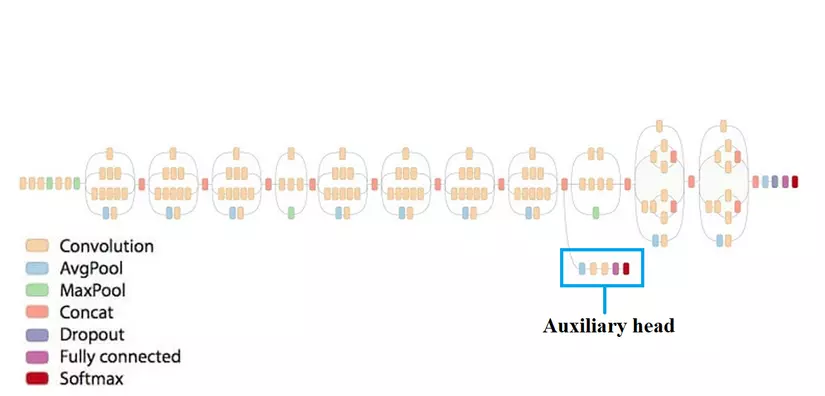

### **2. Kiến trúc của YOLOv7**
- Backbone: ELAN, E-ELAN
- Neck: CSP-SPP và (ELAN, E-ELAN)-PAN
- Head: YOLOR và Auxiliary head


## **II. Tổng kết**

Đây là những kiến thức cơ bản nhất mà mọi cần nắm để hiểu rõ về cấu trúc cũng như cách hoạt động của YOLOv7. Để đi sâu vào cơ sở lý thuyết, hiểu rõ hơn về YOLOv7 mọi người có thể tìm đọc bài báo gốc YOLOv7, và những bài viết blog học thuật chất lượng.


## **III. Reference:**
1. Paper YOLOv7: https://arxiv.org/abs/2207.02696
2. Blog: [[Paper Explain] YOLOv7: Sử dụng các "trainable bag-of-freebies" đưa YOLO lên một tầm cao mới (Phần 1)](https://viblo.asia/p/paper-explain-yolov7-su-dung-cac-trainable-bag-of-freebies-dua-yolo-len-mot-tam-cao-moi-phan-1-zXRJ8BGOVGq) của tác giả Nguyen Mai
3. Blog: [Bài 12 - Các thuật toán Object Detection](https://phamdinhkhanh.github.io/2019/09/29/OverviewObjectDetection.html) - phamdinhkhanh
4. Blog: [Bài 25 - YOLO You Only Look Once](https://phamdinhkhanh.github.io/2020/03/09/DarknetAlgorithm.html) - phamdinhkhanh